In [60]:
from urllib.request import urlopen
import re
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
import pymorphy2

# стоп-слова
russian_stopwords = set(stopwords.words("russian"))

morph = pymorphy2.MorphAnalyzer()
# открываю текст по url
html = urlopen("http://lib.ru/ZELQZNY/legion.txt")
text = " ".join([re.sub('[^А-Яа-я.!?]', " ", line.decode(html.headers.get_content_charset())) for line in html])

# еще я тут добавляю словам части речи, потому что так слова записаны в корпусе
words = [word + '_' + morph.parse(word)[0].tag.POS for word in word_tokenize(re.sub('[,:;.!?]', " ", text.lower())) if morph.parse(word)[0].tag.POS and word not in russian_stopwords]

print(words[:10])

['роджер_NOUN', 'желязны_ADJS', 'имя_NOUN', 'легион_NOUN', 'содержание_NOUN', 'кпк_NOUN', 'роджер_NOUN', 'желязны_ADJS', 'имя_NOUN', 'легион_NOUN']


In [61]:
# чтобы слова не повторялись
vocab = set(words)

In [62]:
from gensim.models import KeyedVectors

# загружаю модель
model = KeyedVectors.load_word2vec_format("w2v_model/model.bin", binary=True, unicode_errors='ignore')

In [63]:
# делаю матрицу из w2v-представлений слов
matrix = [model[word] for word in vocab if model.has_index_for(word)]

print(matrix[:5])

[array([ 0.6334248 ,  0.3554361 , -1.2763747 ,  0.90341455,  0.6050513 ,
        1.0719715 , -0.21818134,  0.7942697 , -0.8587025 , -0.8283613 ,
       -1.1437087 , -0.7702242 , -1.2663685 ,  1.004527  , -0.55313545,
       -0.32734054,  0.48040807, -0.20247658,  0.6198116 , -2.4019501 ,
       -1.3774428 , -0.8375385 , -0.5045415 ,  0.8366932 , -0.3789677 ,
        0.85362995, -2.0385106 ,  1.4503629 , -1.195881  ,  0.646632  ,
        0.6711421 ,  0.15107375,  1.27706   ,  1.8209115 ,  0.02269408,
       -0.06747838, -0.58948034, -1.3992257 ,  3.4623647 ,  0.08657607,
       -0.29814297, -1.5315224 ,  2.2543075 ,  0.21233955,  0.23083249,
       -0.5598778 ,  1.6856544 , -1.1263291 , -0.14485078, -2.8940272 ,
        0.78082484,  1.0631976 ,  1.915561  , -0.13169786, -0.8260265 ,
       -0.8838936 , -0.9101635 ,  0.17905797, -1.7459016 ,  1.9738163 ,
        0.520035  , -3.8697398 , -1.2154052 ,  1.7058223 , -1.6308676 ,
        1.5739396 , -1.389296  ,  0.1122105 ,  1.4904511 ,  1.1

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

k = 20

# через пайплайн нормализую,
# уменьшаю размерность данных до 20
# и кластеризую
pipeline = Pipeline(
    [
        ('normalize', StandardScaler()),
        ('decrease dimensions', PCA(20)),
        ('cluster', KMeans(k))
    ]
)

clusters = pipeline.fit_predict(matrix)
print(clusters)

[10  8  2 ... 11  1  5]


Кластер #0
('автор_NOUN', 0.6548194885253906)
('дом_NOUN', 0.6955554485321045)
('гул_NOUN', 0.6890463829040527)
('организация_NOUN', 0.7706406116485596)
('череп_NOUN', 0.663834810256958)
('обед_NOUN', 0.6453572511672974)
('количество_NOUN', 0.7487549781799316)
('чувство_NOUN', 0.7458736300468445)
('сумка_NOUN', 0.705863356590271)
('письмо_NOUN', 0.5488031506538391)
('звать_VERB', 0.5179353952407837)
('вещество_NOUN', 0.9888945817947388)
('развитие_NOUN', 0.7729489207267761)
('насилие_NOUN', 0.6638438105583191)
('медик_NOUN', 0.8324830532073975)
('электродвигатель_NOUN', 0.6674253940582275)
('сущность_NOUN', 0.7552531361579895)
('берег_NOUN', 0.7834296822547913)
('комната_NOUN', 0.7714114785194397)
('подбородок_NOUN', 0.7866259813308716)
Кластер #1
('организация_NOUN', 0.7697716355323792)
('ночь_NOUN', 0.7804681062698364)
('факт_NOUN', 0.6971875429153442)
('звать_VERB', 0.5216001272201538)
('крик_NOUN', 0.7774449586868286)
('сумка_NOUN', 0.7298128604888916)
('бровь_NOUN', 0.748907268047

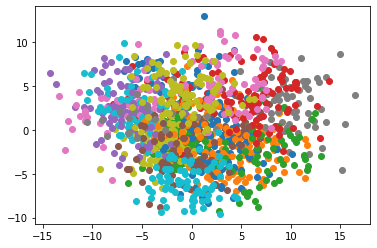

In [67]:
from matplotlib import pyplot as pp

# визуализирую данные
scaler_2 = StandardScaler()
pca_2 = PCA(2)

matrix_scaled_2 = scaler_2.fit_transform(matrix)
matrix_2 = pca_2.fit_transform(matrix_scaled_2)

for cls_ind in range(k):
    print(f'Центроидные слова в кластере # {cls_ind}')

    # если честно Катя подсказала о существовании cluster_centers_
    # и я решила что это норм способ посмотреть что там за кластер вышел
    centers = KMeans(k).fit(matrix_scaled_2).cluster_centers_
    [print(model.most_similar(center_word)[0]) for center_word in centers]

    cls = matrix_2[clusters == cls_ind, :]
    pp.plot(cls[:, 0], cls[:, 1], 'o')

In [88]:
# смотрю все же че за слова в кластерах
vocab_list = [word for word in vocab if model.has_index_for(word)]
words_by_clusters = [[] for _ in range(k)]

for i in range(len(clusters)):
    words_by_clusters[clusters[i]].append(vocab_list[i])

for i in range(k):
    print(f'Слова из кластера #{i}')
    print(words_by_clusters[i][:20])

Слова из кластера #0
['север_NOUN', 'порт_NOUN', 'гряда_NOUN', 'дно_NOUN', 'оконечность_NOUN', 'конус_NOUN', 'место_NOUN', 'залежь_NOUN', 'берег_NOUN', 'путь_NOUN', 'океан_NOUN', 'плавник_NOUN', 'судно_NOUN', 'причал_NOUN', 'ил_NOUN', 'сторона_NOUN', 'море_NOUN', 'обрыв_NOUN', 'дорога_NOUN', 'земля_NOUN']
Слова из кластера #1
['порядок_NOUN', 'акт_NOUN', 'неудобство_NOUN', 'предложение_NOUN', 'угроза_NOUN', 'готовность_NOUN', 'повод_NOUN', 'преемник_NOUN', 'отсутствие_NOUN', 'мнение_NOUN', 'необходимость_NOUN', 'допущение_NOUN', 'причина_NOUN', 'принуждение_NOUN', 'намерение_NOUN', 'суд_NOUN', 'замечание_NOUN', 'допрос_NOUN', 'удовлетворение_NOUN', 'посредство_NOUN']
Слова из кластера #2
['зажегся_VERB', 'машин_NOUN', 'лампу_NOUN', 'сумятица_NOUN', 'иуда_NOUN', 'очистки_NOUN', 'очеловечивание_NOUN', 'мраке_NOUN', 'вест_NOUN', 'ящичка_NOUN', 'кухне_NOUN', 'конспирация_NOUN', 'тел_NOUN', 'мэри_NOUN', 'страха_NOUN', 'черепах_NOUN', 'глазами_NOUN', 'видите_VERB', 'вечера_NOUN', 'игре_NOUN'